In [13]:
import os
import re

from collections import defaultdict

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
METRIC_LITERA = 'BLEU4'

In [78]:
SCORE_DIR = 'scores_regless'
MODEL_DIR = 'mtransformer'

IN_FILENAME = 'gen.out.in'
REF_FILENAME = 'gen.out.ref'

SYS_FILENAME = 'gen.out.sys'
SCORE_FILENAME = 'score.out'

RAW_FILENAME = 'gen.out'

scores_path = os.path.join(MODEL_DIR, SCORE_DIR)

In [90]:
beam2in = defaultdict(list)
beam2ref = defaultdict(list)

beam2sys = defaultdict(list)
beam2score = defaultdict(list)

beam2bleu = defaultdict(list)
beam2sid = defaultdict(list)

beam2total = {}

for beam_folder in os.listdir(scores_path):
    beam_width = int(beam_folder[1:])
    beam_path = os.path.join(scores_path, beam_folder)
    
    with open(os.path.join(beam_path, IN_FILENAME)) as input_stream:
        beam2in[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, REF_FILENAME)) as input_stream:
        beam2ref[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, SYS_FILENAME)) as input_stream:
        beam2sys[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, SCORE_FILENAME)) as input_stream:
        beam2score[beam_width] = input_stream.readlines()
        
    with open(os.path.join(beam_path, RAW_FILENAME)) as input_stream:
        beam2total[beam_width] = float(re.split(
            ',|\s',
            input_stream.readlines()[-1]
        )[7])

In [91]:
for beam_width in beam2score:
    beam2score[beam_width] = beam2score[beam_width][1:]
    
    beam2bleu[beam_width] = [float(re.split(',|\s', x)[3]) for x in beam2score[beam_width]]
    beam2sid[beam_width] = [int(re.split(',|\s', x)[0]) for x in beam2score[beam_width]]

In [92]:
beam2pack = defaultdict(tuple)

for beam in beam2in:
    beam2pack[beam] = (
        np.array(beam2in[beam]),
        np.array(beam2ref[beam]),
        np.array(beam2sys[beam]),
        np.array(beam2bleu[beam]),
    )

In [100]:
beam_widths, scores = np.array(list(beam2total.keys())), np.array(list(beam2total.values()))

In [102]:
idx_s = np.argsort(beam_widths)

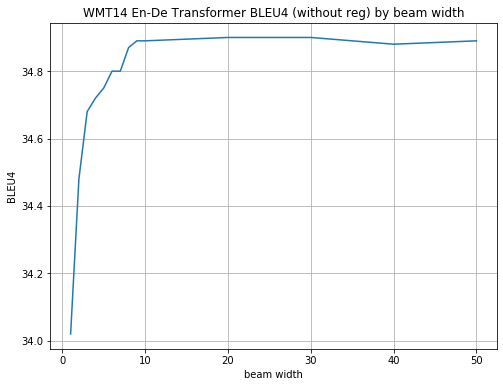

In [105]:
plt.figure(figsize=(8, 6))

plt.plot(beam_widths[idx_s], scores[idx_s])
plt.xlabel('beam width')
plt.ylabel('BLEU4')
plt.title('WMT14 En-De Transformer BLEU4 (without reg) by beam width')
plt.grid()

In [108]:
def get_worst_predictions(inputs, targets, preds, bleu_scores, k):
    idxs_s = np.argsort(bleu_scores)
    out_idxs = idxs_s[:k]
    
    return inputs[out_idxs], targets[out_idxs], preds[out_idxs], bleu_scores[out_idxs]

In [110]:
TOP_K_VALUE = 20

for beam in sorted(beam2pack.keys()):
    inputs, targets, preds, bleu_scores = get_worst_predictions(*beam2pack[beam], TOP_K_VALUE)
    print('$$$', beam)
    for input_sent, target, pred, bleu in zip(inputs, targets, preds, bleu_scores):
        print('\n')
        print('\t', 'INPUT:', input_sent)
        print('\t', 'TARGET:', target)
        print('\t', 'PREDICTION:', pred)
        print('\t', 'BLEU:', bleu)

$$$ 1


	 INPUT: toller trick ?

	 TARGET: nice one .

	 PREDICTION: great trick ?

	 BLEU: 0.0


	 INPUT: die frage ist , was kommt jetzt ?

	 TARGET: we &apos;re still extremely attached to storytelling as a method of information brokerage .

	 PREDICTION: the question is , what &apos;s going on here ?

	 BLEU: 0.0


	 INPUT: was hat einflüsse auf unsere auf unser denken und auf unser erinnerungsvermögen ?

	 TARGET: from the age of feudalism to the to the machine age .

	 PREDICTION: what does impacts our thinking and our memory ?

	 BLEU: 0.0


	 INPUT: dann sind das verblassenden einflüsse der vorindustriellen kulturen .

	 TARGET: what has an influence on our on our thinking and our ability to remember ?

	 PREDICTION: then these are formidable influences of pre-industrial culture .

	 BLEU: 0.0


	 INPUT: sie ist etwas , was nicht von stopp stofflicher , materieller natur ist .

	 TARGET: and when you are with people who are firmly convinced that you have a soul , or , you might

$$$ 20


	 INPUT: toller trick ?

	 TARGET: nice one .

	 PREDICTION: great trick ?

	 BLEU: 0.0


	 INPUT: die frage ist , was kommt jetzt ?

	 TARGET: we &apos;re still extremely attached to storytelling as a method of information brokerage .

	 PREDICTION: the question is , what &apos;s next ?

	 BLEU: 0.0


	 INPUT: dann sind das verblassenden einflüsse der vorindustriellen kulturen .

	 TARGET: what has an influence on our on our thinking and our ability to remember ?

	 PREDICTION: then these are abandoned influences of pre-industrial culture .

	 BLEU: 0.0


	 INPUT: was hat einflüsse auf unsere auf unser denken und auf unser erinnerungsvermögen ?

	 TARGET: from the age of feudalism to the to the machine age .

	 PREDICTION: what impacts our thinking and our memory ?

	 BLEU: 0.0


	 INPUT: machen wir eine kleine zwischenbilanz .

	 TARGET: bruce brown , a famous design researcher at brighton university , went so far as to say that mass media and he means books and images , not